## Imports

In [56]:
# models
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# model selection
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.decomposition import PCA

# preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

# utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum

## Data loading

In [2]:
data_dir = "data"

X_g_train = np.load(f"{data_dir}/guided/guided_dataset_X.npy")
y_g_train = np.load(f"{data_dir}/guided/guided_dataset_y.npy")
X_g_test = np.load(f"{data_dir}/guided/guided_testset_X.npy")

X_f_train = np.load(f"{data_dir}/freemoves/freemoves_dataset_X.npy")
y_f_train = np.load(f"{data_dir}/freemoves/freemoves_dataset_y.npy")
X_f_test = np.load(f"{data_dir}/freemoves/freemoves_testset_X.npy")


In [3]:
print("Guided:")
print(f"X_g_train {X_g_train.shape} / y_g_train{y_g_train.shape} / X_g_test{X_g_test.shape}\n")
print("Free moves:")
print(f"X_f_train{X_f_train.shape} / y_f_train{y_f_train.shape} / X_f_test{X_f_test.shape}")

Guided:
X_g_train (5, 8, 230000) / y_g_train(5, 51, 230000) / X_g_test(5, 332, 8, 500)

Free moves:
X_f_train(5, 8, 270000) / y_f_train(5, 51, 270000) / X_f_test(5, 308, 8, 500)


## Data preparation

In [4]:
class FeatureWindowAugment(BaseEstimator, TransformerMixin):
    """
    + Augment X through overlapping windows
    """
    
    def __init__(self, window_size=500, overlap=0.5):
        self.window_size = window_size
        self.overlap = overlap
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        axis = 2 # time
        step = int(self.window_size * (1 - self.overlap))
        
        # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
        X_windows = np.lib.stride_tricks.sliding_window_view(X,self.window_size, axis)

        # only keep windows where the step is a multiple of our step 
        X_windows = X_windows[:,:,::step,:]
         
        # (session, electrode, window, time) to (session, window, electrode, time)
        X_windows = X_windows.transpose(0, 2, 1, 3) 
        
        return X_windows   

In [5]:
class TargetStrategy(Enum):
    """
    strategy to select the target (unique hand pose) from a window
    """
    
    MEAN = 0
    FIRST = 1
    LAST = 2
    MEDIAN = 3
    
class WindowTargetExtractor(BaseEstimator, TransformerMixin):
    """
    + augment y through overlapping windows 
    + extract the target, i.e. unique hand pose (51 val) of the correspondoing window (500 'samples')
    """
    
    def __init__(self, window_size=500, overlap=0.5, target_strat=TargetStrategy.LAST):
        self.window_size = window_size
        self.overlap = overlap
        self.target_strat = target_strat
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, y):
        axis = 2 # time
        step = int(self.window_size * (1 - self.overlap))
        
        # ----- window augment -----
        
        # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
        y_windows = np.lib.stride_tricks.sliding_window_view(y,self.window_size, axis)

        # only keep windows where the step is a multiple of our step 
        y_windows = y_windows[:,:,::step,:]
         
        # (session, angles, window, time) to (session, window, angles, time)
        y_windows = y_windows.transpose(0, 2, 1, 3)     
        
        # ----- target extract -----

        match self.target_strat:
            case TargetStrategy.LAST:
                y_windows = y_windows[:, :, :, -1]
            case TargetStrategy.FIRST:
                y_windows = y_windows[:, :, :, 0]
            case TargetStrategy.MEAN:
                y_windows = np.mean(y_windows, axis=3)
            case TargetStrategy.MEDIAN:
                y_windows = np.median(y_windows, axis=3)
            case _:
                raise ValueError(f"Unknown TargetStrategy enum value")
        
        return y_windows

Windowed data

In [6]:
X_g_train_wdw = FeatureWindowAugment().transform(X_g_train)
y_g_train_wdw = WindowTargetExtractor().transform(y_g_train)

print("Guided windowed:")
print(f"X_g_train_wdw {X_g_train_wdw.shape} / X_g_test {X_g_test.shape}")
print(f"y_g_train_wdw{y_g_train_wdw.shape}")

Guided windowed:
X_g_train_wdw (5, 919, 8, 500) / X_g_test (5, 332, 8, 500)
y_g_train_wdw(5, 919, 51)


## Common time features extraction

extract features from X set windows
+ Mean Absolute Value (MAV)
+ Root Mean Square (RMS)
+ Variance (VAR)
+ Standard Deviation (STD)
+ Zero Crossing (ZC)
+ Myopulse Percentage Rate (MPR)

In [7]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Extracts common time-domain features, from numpy arrays into a dataframe (readability)
    """

    def __init__(self, mpr_threshold=0.5):
        self.mpr_threshold = mpr_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):        
        # --- Feature extraction ---
        feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR']
        n_features = len(feature_names)
        
        n_sessions, n_windows, n_electrodes, n_times = X.shape
        features = np.zeros((n_sessions * n_windows, n_electrodes * n_features))
        
        for s in range(n_sessions):
            for w in range(n_windows):
                i = s*n_windows + w # index in flattened contiguous windows samples 'form'
                wdw_features = []
                for e in range(n_electrodes):
                    signal = X[s, w, e, :] # window signal
                    
                    mav = np.mean(np.abs(signal))
                    rms = np.sqrt(np.mean(signal**2))
                    var = np.var(signal)
                    std = np.std(signal)
                    zc = np.sum(np.diff(np.signbit(signal)).astype(int))
                    mpr = np.mean(np.abs(signal) > self.mpr_threshold)    
                    wdw_features.extend([mav, rms, var, std, zc, mpr])
                
                features[i, :] = wdw_features
        
        # # --- to Dataframe ---            
        # column_names = [f"elec{e}_{name}" for e in range(n_electrodes) for name in feature_names]
        # df = pd.DataFrame(features, columns=column_names)
        
        return features

In [8]:
class TargetFlattener(BaseEstimator, TransformerMixin):
    """
    Flatten feature set for sklearn usability
    """

    def fit(self, y, X=None):
        return self

    def transform(self, y, X=None):      
        
        # -- Reshape --
        n_sessions, n_windows, n_angles = y.shape
        
        # Reshape to (sessions*windows, angles)
        y_flat = y.reshape(n_sessions * n_windows, n_angles)
        
        # n_vals = 3 # 3 'values' per joint angle
        # column_names = [f"angle{i}_{k}" for i in range(0, n_angles, n_vals) for k in range(n_vals)]
        
        # df = pd.DataFrame(y_flat, columns=column_names)
        
        return y_flat

Preprocessed data 

In [9]:
X_g_train_preproc = FeatureExtractor().transform(X_g_train_wdw)
y_g_train_preproc = TargetFlattener().transform(y_g_train_wdw)

print("Guided preprocessed:")
print(f"X_g_train_preproc {X_g_train_preproc.shape} / X_g_test {X_g_test.shape}")
print(f"y_g_train_preproc{y_g_train_preproc.shape}")

Guided preprocessed:
X_g_train_preproc (4595, 48) / X_g_test (5, 332, 8, 500)
y_g_train_preproc(4595, 51)


## Cross validation

strategy: session based Leave One Group Out

+ no **window overlap leakage**
+ avoids **session bias**: signal drift, sensors placements, ... 

In [ ]:
n_sessions, n_windows, n_electrodes, n_times = X_g_train_wdw.shape
groups = np.repeat(np.arange(1,n_sessions+1), n_windows) # [1 ... 1], [2 ... 2], ..., [5 ...5] each group of lenght n_windows

# loss functions
def mse(y_true, y_hat):
    return np.mean((y_true-y_hat)**2)
def rmse(y_true, y_hat):
    return np.sqrt(np.mean((y_true-y_hat)**2))
def nmse(y_true, y_hat):
    return np.mean((y_true-y_hat)**2)/np.std(y_true)**2

# scorers
rmse_scorer = make_scorer(rmse, greater_is_better=False)
nmse_scorer = make_scorer(nmse, greater_is_better=False)

# cv function 
logo = LeaveOneGroupOut()
def logo_cv(X, y, model, scorer=rmse_scorer):
    cv_scores = cross_val_score(model, X, y, groups=groups, cv=logo, scoring=scorer, n_jobs=-1)
    return np.mean(-cv_scores)

def _logo_cv(X, y, model):
    cv_nmse = []
    cv_rmse = []
    for train_index, test_index in logo.split(X, y, groups):
        X_tr, X_ts = X[train_index], X[test_index]
        y_tr, y_ts = y[train_index], y[test_index]
        
        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_ts)
        cv_nmse.append(nmse(y_ts, y_hat))
        cv_rmse.append(rmse(y_ts, y_hat))
        
    return (np.mean(cv_rmse), np.mean(cv_nmse))

## Baseline

we try multiple models from low to medium complexity of different families of models (tree, linear,...) to get an idea of a baseline cv score, model complexity impact (bias, variance) on data and model family preferences.

+ To guide further model development strategically (no bruteforce - try all)
+ simpel models, goal: give a cv 'upperbound' that any more complex models should beat otherwise not worth the complexity
+ data-model fit, different model (families) make different data assumptions
+ get early signals of what could work !


In [11]:
cv_results_baselines = {}
from sklearn.dummy import DummyRegressor
baselines = {
    'dummy_mean': DummyRegressor(strategy='mean'),
    'Ridge': Ridge(),
    "OLS": LinearRegression(),
    'random_forest': RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=10),
    'decision_tree': DecisionTreeRegressor(random_state=0)
}

for name, model in baselines.items():
    cv_rmse, cv_nmse = _logo_cv(X_g_train_preproc, y_g_train_preproc, model)
    cv_results_baselines[name] = {"RMSE": cv_rmse, "NMSE": cv_nmse}

baselines_cv_df = pd.DataFrame(cv_results_baselines).T
baselines_cv_df

,RMSE,NMSE
dummy_mean,14.259043,0.437812
Ridge,7.395048,0.118309
OLS,7.248052,0.113622
random_forest,5.094033,0.056900
decision_tree,7.086189,0.110000


#### Baselines Tuning and observations

In [24]:
depths = [2, 5, 10, 20, None] # depth=None puts no limit on tree depth (until all leaves pure) 

dt_rmse_values = []
dt_nmse_values = []
for depth in depths:
    dt_reg = DecisionTreeRegressor(random_state=0, max_depth=depth)
    cv_rmse, cv_nmse = _logo_cv(X_g_train_preproc, y_g_train_preproc, dt_reg)
    dt_rmse_values.append(cv_rmse)
    dt_nmse_values.append(cv_nmse)


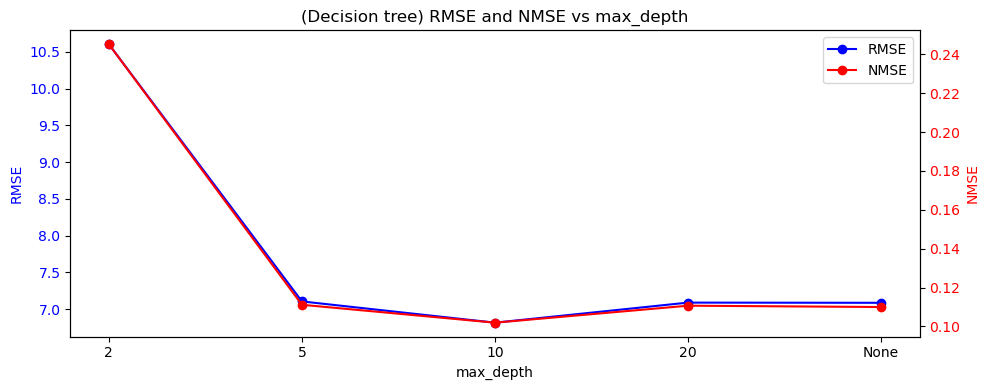

In [31]:
# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

# Plot RMSE on left axis
line1 = ax1.plot([str(d) for d in depths], dt_rmse_values, 'b-o', label='RMSE')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('RMSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot NMSE on right axis
line2 = ax2.plot([str(d) for d in depths], dt_nmse_values, 'r-o', label='NMSE')
ax2.set_ylabel('NMSE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title('(Decision tree) RMSE and NMSE vs max_depth')
plt.tight_layout()
plt.show()

In [36]:
estimators_range = [10, 20, 50, 100]
rf_rmse_values = []
rf_nmse_values = []
for n in estimators_range:
    rf_reg = RandomForestRegressor(random_state=0, n_estimators=n, n_jobs=-1)
    cv_rmse, cv_nmse = _logo_cv(X_g_train_preproc, y_g_train_preproc, rf_reg)
    rf_rmse_values.append(cv_rmse)
    rf_nmse_values.append(cv_nmse)

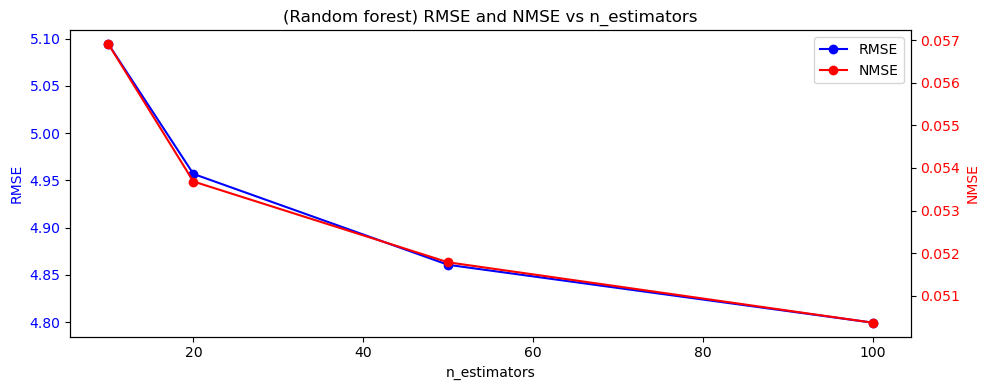

In [38]:
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

# Plot RMSE on left axis
line1 = ax1.plot(estimators_range, rf_rmse_values, 'b-o', label='RMSE')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('RMSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot NMSE on right axis
line2 = ax2.plot(estimators_range, rf_nmse_values, 'r-o', label='NMSE')
ax2.set_ylabel('NMSE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title('(Random forest) RMSE and NMSE vs n_estimators')
plt.tight_layout()
plt.show()

decision tree param search

In [68]:
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Using just 50 estimators for parameter search
dt = DecisionTreeRegressor(random_state=0)
dt_search = RandomizedSearchCV(dt, param_grid, n_iter=20, cv=logo, n_jobs=-1, random_state=0, scoring=rmse_scorer)
dt_search.fit(X_g_train_preproc, y_g_train_preproc, groups=groups)

# Use best parameters with more estimators for final model
dt_best_params = dt_search.best_params_

best_dt = DecisionTreeRegressor(
    **dt_best_params,
    random_state=0
)

print(f"Best Decision tree RMSE: {-dt_search.best_score_}")

Best Decision tree RMSE: 6.4147967074223615


random forest param search

In [66]:
param_grid = {
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

# Using just 50 estimators for parameter search
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=0)
rf_search = RandomizedSearchCV(rf, param_grid, n_iter=20, cv=logo, n_jobs=-1, random_state=0, scoring=rmse_scorer)
rf_search.fit(X_g_train_preproc, y_g_train_preproc, groups=groups)

# Use best parameters with more estimators for final model
rf_best_params = rf_search.best_params_

best_rf = RandomForestRegressor(
    n_estimators=10, # TODO: more
    **best_params,
    n_jobs=-1, 
    random_state=0
)
print(f"Best Random forest RMSE: {-rf_search.best_score_}")


Best Random forest RMSE: 4.8624931202641015


Ridge/Lasso param search ?

#### Baselines feature importance

In [53]:
# name features --> numpy to dataset ? for readability
best_dt.fit(X_g_train_preproc, y_g_train_preproc)
best_dt.feature_importances_

array([3.25818668e-02, 6.54471994e-03, 6.70558816e-02, 3.19047837e-03,
       2.43512548e-04, 1.25878003e-04, 1.32884992e-01, 1.06514469e-02,
       2.81225289e-02, 3.18639062e-03, 1.40270993e-04, 1.44549048e-04,
       6.30430281e-02, 3.52199619e-04, 2.67842872e-04, 3.03292994e-03,
       6.76979007e-04, 9.18653286e-05, 2.38064080e-01, 2.36138606e-03,
       1.20556815e-03, 4.71853626e-03, 1.37932179e-03, 3.44351137e-04,
       3.14112275e-02, 2.62965470e-02, 3.71238178e-04, 9.83411209e-04,
       2.00931627e-03, 6.08779513e-04, 2.70984252e-03, 4.16311597e-04,
       1.71353993e-03, 4.78136707e-04, 3.51812621e-04, 8.26581715e-05,
       4.67632948e-03, 2.90923862e-01, 5.34158276e-04, 3.69626556e-03,
       2.16553438e-03, 2.02666711e-04, 1.02423209e-02, 1.07453530e-02,
       3.18770142e-03, 2.59628898e-04, 4.65022063e-03, 8.72534343e-04])

In [52]:
# name features --> numpy to dataset ? for readability
best_rf.fit(X_g_train_preproc, y_g_train_preproc)
best_rf.feature_importances_

array([0.01367497, 0.02392511, 0.03391511, 0.03239044, 0.00228294,
       0.00244468, 0.06057745, 0.04634403, 0.02067511, 0.05736627,
       0.00057263, 0.0003761 , 0.02347488, 0.00434588, 0.01427184,
       0.02538963, 0.00248638, 0.00146103, 0.09631389, 0.03908436,
       0.04599329, 0.05122139, 0.0011453 , 0.00096811, 0.06375306,
       0.00628995, 0.00785559, 0.00389147, 0.00165931, 0.00123787,
       0.00332309, 0.0009558 , 0.0016618 , 0.00183248, 0.00082101,
       0.00077678, 0.06699905, 0.0691134 , 0.0605891 , 0.07419563,
       0.00041529, 0.00076901, 0.01114525, 0.0023504 , 0.00546862,
       0.00468001, 0.00554549, 0.00396969])

In [54]:
ols_reg = LinearRegression(n_jobs=-1)
ols_reg.fit(X_g_train_preproc, y_g_train_preproc)
ols_reg.coef_

array([[-1.21206878e-01,  2.21426627e+00,  5.07624528e-05, ...,
        -9.09565053e-01, -2.32902380e-02,  2.02257342e+00],
       [ 4.95813099e-02, -3.35737993e-01,  1.45101353e-05, ...,
         3.28528239e-01,  1.19747032e-02, -2.01353841e+00],
       [ 3.72438592e-01, -6.24607410e+00, -1.09021920e-04, ...,
         2.70667745e+00,  7.43911615e-02, -7.58981164e+00],
       ...,
       [-3.49183156e-02, -3.47237592e-01,  7.56203592e-05, ...,
        -2.34784997e-01, -8.42285155e-04, -2.55170576e+00],
       [ 2.09936606e-02,  2.13793870e-01, -3.71913336e-05, ...,
         1.15273524e-01,  9.06746921e-04,  1.48786985e+00],
       [-9.36670871e-01, -9.17316248e+00,  1.91462609e-03, ...,
        -5.96235710e+00, -2.70780321e-02, -6.57575968e+01]])

multi output regression, so OLS coeffs has shape (n_target, n_features), each target (51 joint angles) has its own regression model with a weight associated to every feature (48)

```python
coef_ = np.array([
    [w_1_1, w_1_2, ..., w_1_48],  # weights of angle 1 model
    [w_2_1, w_2_2, ..., w_2_48],  # weights of angle 1 model
    ...
    [w_51_1, ..., w_51_48]        # weights of angle 1 model
])
```

#### Baselines feature selection

TODO: tp 5 methods
+ correl
+ wrapper
+ PCA
+ mRMR

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_g_train_preproc)
logo_cv(X_pca, y_g_train_preproc, best_rf, rmse_scorer)

np.float64(5.337954289507091)

#### Best baseline

In [ ]:
best_baseline_pipe = make_pipeline(
    FeatureExtractor(),
    # best feature selection,
    # best_baseline_model
)

### More complex model